In [1]:
import matplotlib.pyplot as plt
from scipy.sparse import diags,csr_matrix
from scipy.integrate import simpson
from scipy.sparse.linalg import spsolve,eigsh
import scipy as scp
import numpy as np
import sympy as sp

In [51]:
def fd_weights ( offsets , order , show_system = False ) :

    """
    Name          : fd_weights -> finite difference weights
    Purpose       : calculate the set of coefficients for a finite difference
                    approximation of the order-th derivative using the given
                    offsets. We are essentually solving the linear system
                    A c = b, where A is the Vandermonde matrix of the offsets,
                    c is the vector of coefficients we want to find, and b is
                    a vector of zeros with a factorial(order) in the order-th
                    position.
    Author          : christlieb, augmented by Joshua Belieu.
    Date augmented  : 2025-08-26
    Last modified   : 2025-08-26
    Inputs :
        - offsets     : list. list of offsets (in units of grid stride h)
        - order       : int. order of derivative to approximate
        - show_system : bool. if True, print the system of equations being
                        solved. default is False.
    Outputs:
        - <ret>: <type> ... <meaning/units/shape>
    Dependencies:
        - None.
    """

    '''
    list of offsets (in units of grid stride h), nsimplify allows floats.
    '''

    s = [ sp.nsimplify ( offset ) for offset in offsets ]
    m = len ( s )

    '''
    the Vandermonde matrix of the offsets. the "A" in our system Ac = b
    '''

    A = sp.Matrix ([[ s[j] ** k for j in range ( m ) ] for k in range ( m )])

    '''
    a vector of zeros with a factorial(order) in the order-th position. the 
    "b" in our system Ac = b.
    '''

    b = sp.Matrix ( [ 0 ] * m )
    b [ order ] = sp.factorial ( order )

    '''
    the coefficients we want to find. the "c" in our system Ac = b. LUsolve is 
    a decomposition method that splits A into a lower and upper triangular matrix
    and solves the system (Ux=y and Ly=c) in two steps.
    '''

    c = A.LUsolve ( b )

    if show_system :

        system = sp.Eq( sp.MatMul ( A , c , evaluate = False ) , b )
        sp.pprint(system)

    return sp.simplify ( c )

h not specified, assuming h = 1.0


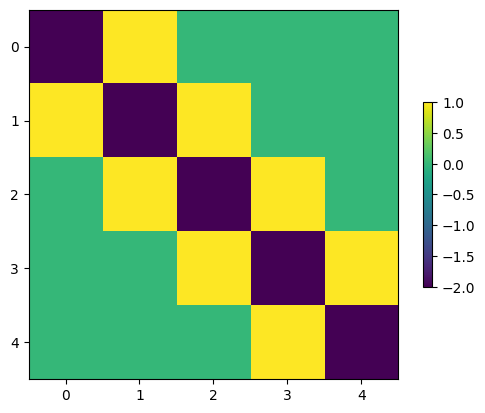

In [52]:
def derivative_1d_stencil ( n = 5 , offsets = [-1,0,1] , order = 2 , h = None ) :

    """
    Name: derivative_1d_stencil
    Purpose: what this subroutine computes and why
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-24
    Last modified: 2025-09-24
    Inputs:
    - arg1: type ... meaning/units/shape
    - arg2: type ... meaning/units/shape
    Outputs:
    - ret: type ... meaning/units/shape
    Dependencies:
    - SubroutineA, SubroutineB, ...
    """

    if h == None :
        print ( "h not specified, assuming h = 1.0" )
        h = 1.0

    weights = [ float(num) for num in np.array(fd_weights ( offsets , order )).flatten()]

    stencil = diags ( weights , offsets , shape = ( n , n ) ) / h**order

    return stencil.toarray()

'''
unit test
'''
test_deriv = derivative_1d_stencil()
plt.imshow(test_deriv)
plt.colorbar(shrink=0.5);

In [3]:
"""
Name: find eigenvalues of TGS
Purpose: what this subroutine computes and why
Author: Joshua Belieu | Fletch
Date written: YYYY-MM-DD
Last modified: YYYY-MM-DD
Inputs:
- arg1: type ... meaning/units/shape
- arg2: type ... meaning/units/shape
Outputs:
- ret: type ... meaning/units/shape
Dependencies:
- SubroutineA, SubroutineB, ...
"""
#MAYBE DELETE.
n=32
h=1/(n-1)
e = np.ones(n)
D = -2/h**2 * diags( e , offsets=0,shape=(n,n))
U = 1/h**2 * diags( e , offsets=1,shape=(n,n))
L = 1/h**2 * diags( e , offsets=-1,shape=(n,n))
theta_k = lambda k : (k*n.pi)/(n+1)
eigen_vec = lambda k,x : np.sin(theta_k(k)*x)
gauss_seidel_iteration_matrix = -np.linalg.inv ( (D-L).toarray() ) @ ( U ).toarray()

0.1.b

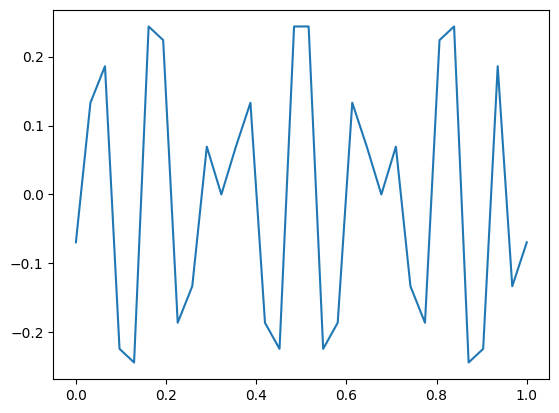

In [29]:
n=32
h=1/(n+1)
e = np.ones(n)
D = -2/h**2 * diags( e , offsets=0,shape=(n,n))
U = 1/h**2 * diags( e , offsets=1,shape=(n,n))
L = 1/h**2 * diags( e , offsets=-1,shape=(n,n))
tgs = -np.linalg.inv(D.toarray() + L.toarray()) @ U.toarray() # gs iteratoin matrix
tgs = -np.linalg.inv ( D.toarray() ) @ ( L + U ).toarray() # this is jacobi but im playing rn
_ , tgs_evecs = np.linalg.eigh(tgs)
x = np.linspace(0.,1.,n)
plt.plot(x,tgs_evecs[2]);

In [19]:
def spectral_radius ( matrix ) :

    """
    Name: spectral_radius
    Purpose: compute the spectral radius of a given matrix
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-30
    Last modified: 2025-09-30
    Inputs:
    - matrix : ndarray/sparse matrix. the matrix to find the spectral radius of.
    Outputs:
    - max_eigenval : float. the absolute value of the largest eigenval
    Dependencies:
    - None.
    """

    eigenvals = np.linalg.eigvals ( matrix )

    max_eigenval = np.max ( np.abs ( eigenvals ) )

    return max_eigenval

In [5]:
def jacobi_iteration ( b , u0 = None , tolerance = 1e-5 , max_iteration = 1000 , show_final_stats = False ) :

    """
    Name: jacobi_iteration
    Purpose: use the jacobi iteration method to solve an ODE/PDE
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-30
    Last modified: 2025-10-01
    Inputs:
    - b : ndarray. the RHS of the differential equation
    - u0 : ndarray. the initial guess for the solution, u. default value is None
           which generates a nxn array of zeros.
    - tolerance : float. the desired tolerance in the convergance of successive 
                  u iterates. default value is 1e-5.
    - max_iteratoin : int. the maximum iterations for the while loop. default
                      value is 1000.
    - show_final_stats : bool. if True, it shows the final iteration and max
                         absolute error.
    Outputs:
    - u : ndarray. an nxn array of the solution.
    - u_iterate_list : list. a collection of u vectors at different iterates
    - iterate_list : list. a collection of iterations.
    Dependencies:
    - boundary conditions. at time of writing homogenous dirichlet boundary
      conditions are used.
    """

    n = b.shape[0]
    h = 1 / ( n - 1 )
    boundary_indices = [ 0 , n - 1  ]

    error = 1
    iteration = 0

    iterates_list = []
    u_iterate_list = []

    if b.ndim == 1 :
            
            if u0 is None :
                u = np.zeros(shape=(n))
            else :
                u = u0.copy()
            
            while error > tolerance and iteration < max_iteration :
                u_new = np.zeros_like ( u )
                iterates_list.append(iteration)
                u_iterate_list.append(u)
                for i in range ( n ) :
                        if i in boundary_indices :
                            u_new[i] = 0 # boundary conditions
                        else : 
                            u_new[i] = 0.5 * ( u[i+1] + u[i-1] ) - h ** 2 / 2 * b[i]
                error = np.max(np.abs(u_new - u))
                u = u_new
                iteration += 1
    
    if b.ndim == 2 :

        if u0 is None :
            u = np.zeros(shape=(n,n))
        else :
            u = u0.copy()

        while error > tolerance and iteration < max_iteration :
            u_new = np.zeros_like ( u )
            iterates_list.append(iteration)
            u_iterate_list.append(u)
            for i in range ( n ) :
                for j in range ( n ) :
                    if i in boundary_indices or j in boundary_indices :
                        u_new[i,j] = 0 # boundary conditions
                    else : 
                        u_new[i,j] = 0.25 * ( u[i,j+1] + u[i,j-1] + u[i+1,j] + u[i-1,j] ) - h ** 2 / 4 * b[i,j]
            error = np.max(np.abs(u_new - u))
            u = u_new
            iteration += 1

    if show_final_stats == True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {error:.2e}'
        print(out_str)

    return u,u_iterate_list,iterates_list

'''
unit test
'''

unit_test_flag = 0

if unit_test_flag == 1 :

    n = 32
    b = np.zeros((n,n))
    x = np.linspace ( 0 , 1 , n );
    y = np.linspace ( 0 , 1 , n );
    for i in range ( n ) :
        for j in range ( n ) :
            if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
                b[i,j] = -1

    u_sol,_,_ = jacobi_iteration(b,tolerance=1e-10,max_iteration=int(1e4),show_final_stats=True)
    X, Y = np.meshgrid(x, x)

    fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
    ax1 = fig.add_subplot ( 121 )
    ax2 = fig.add_subplot ( 122 , projection = '3d' )

    im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
    fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
    ax1.set_title("u(x,y)")

    im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
    fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")
    ax2.set_title("u(x,y)");

In [6]:
def gauss_seidel_iteration ( b , u0 = None , tolerance = 1e-5 , max_iteration = 1000 , show_final_stats = False ) :

    """
    Name: gauss_seidel_iteration
    Purpose: Solve Au=b for u via the Gauss-Seidel iterative method.
    Author: Joshua Belieu | Fletch
    Date written: 2025-10-01
    Last modified: 2025-10-01
    Inputs:
    - b : ndarray. the RHS of the differential equation
    - u0 : ndarray. the initial guess for the solution, u. default value is None
           which generates a nxn array of zeros.
    - tolerance : float. the desired tolerance in the convergance of successive 
                  u iterates. default value is 1e-5.
    - max_iteratoin : int. the maximum iterations for the while loop. default
                      value is 1000.
    - show_final_stats : bool. if True, it shows the final iteration and max
                         absolute error.
    Outputs:
    - u : ndarray. an nxn array of the solution.
    - u_iterate_list : list. a collection of u vectors at different iterates
    - iterate_list : list. a collection of iterations.
    Dependencies:
    - boundary conditions. at time of writing homogenous dirichlet boundary
      conditions are used.
    """

    n = b.shape[0]
    h = 1 / ( n - 1 )
    boundary_indices = [ 0 , n - 1  ]

    error = 1.
    iteration = 0

    iterates_list = []
    u_iterate_list = []

    if b.ndim == 1 :
            
            if u0 is None :
                u = np.zeros(shape=(n))
            else :
                u = u0.copy()
            
            while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
                u_new = np.zeros_like ( u )
                iterates_list.append(iteration)
                u_iterate_list.append(u)
                for i in range ( n ) :
                        if i in boundary_indices :
                            u_new[i] = 0 # boundary conditions
                        else : 
                            u_new[i] = 0.5 * ( u[i+1] + u_new[i-1] ) - h ** 2 / 2 * b[i]
                error = u_new - u
                u = u_new
                iteration += 1
    
    elif b.ndim == 2 :

        if u0 is None :
            u = np.zeros(shape=(n,n))
        else :
            u = u0.copy()

        while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
            u_new = np.zeros_like ( u )
            iterates_list.append(iteration)
            u_iterate_list.append(u)
            for i in range ( n ) :
                for j in range ( n ) :
                    if i in boundary_indices or j in boundary_indices :
                        u_new[i,j] = 0 # boundary conditions
                    else : 
                        u_new[i,j] = 0.25 * ( u[i,j+1] + u_new[i,j-1] + u[i+1,j] + u_new[i-1,j] ) - h ** 2 / 4 * b[i,j]
            error = u_new - u
            u = u_new
            iteration += 1

    if show_final_stats == True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print(out_str)

    return u,u_iterate_list,iterates_list

'''
unit test
'''

unit_test_flag = 0

if unit_test_flag == 1 :

    n = 32
    b = np.zeros((n,n))
    x = np.linspace ( 0 , 1 , n );
    y = np.linspace ( 0 , 1 , n );
    for i in range ( n ) :
        for j in range ( n ) :
            if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
                b[i,j] = -1

    u_sol,_,_ = gauss_seidel_iteration(b,tolerance=1e-10,max_iteration=int(1e4),show_final_stats=True)
    X, Y = np.meshgrid(x, x)

    fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
    ax1 = fig.add_subplot ( 121 )
    ax2 = fig.add_subplot ( 122 , projection = '3d' )

    im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
    fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
    ax1.set_title("u(x,y)")

    im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
    fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")
    ax2.set_title("u(x,y)");

0.1.c

In [7]:
"""
Name: show spectral radius
Purpose: compute the spectral radius of the jacobi and gauss-seidel methods to
         give us an idea of the convergance of the methods.
Author: Joshua Belieu | Fletch
Date written: 2025-10-01
Last modified: 2025-10-01
Inputs:
- n : int. number of mesh points
Outputs:
- spectral radius : float. the spectral radius of jacobi and gauss-seidel iteration
                    matrices
Dependencies:
- diags, spectral_radius, numpy
"""

n = 32
h = 1/(n-1)

e = np.ones(n)
D = -2/h**2 * diags( e , offsets=0,shape=(n,n))
U = 1/h**2 * diags( e , offsets=1,shape=(n,n))
L = 1/h**2 * diags( e , offsets=-1,shape=(n,n))

jacobi_iteration_matrix = -np.linalg.inv ( D.toarray() ) @ ( L + U ).toarray()
gauss_seidel_iteration_matrix = -np.linalg.inv ( (D-L).toarray() ) @ ( U ).toarray()

jacobi_spectral_radius = spectral_radius ( jacobi_iteration_matrix )
gauss_seidel_spectral_radius = spectral_radius ( gauss_seidel_iteration_matrix )

print(jacobi_spectral_radius,gauss_seidel_spectral_radius)

0.9954719225730841 0.9909643486313532


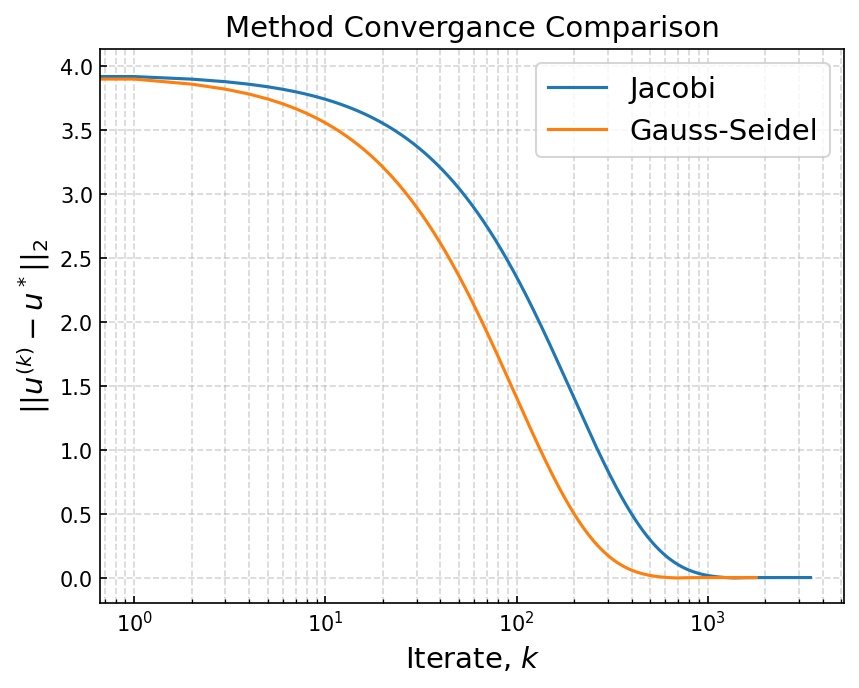

In [8]:
"""
Name: method convergance comparison
Purpose: make a plot showing the convergance of the gauss-seidel and jacobi 
         iteration methods.
Author: Joshua Belieu | Fletch
Date written: 2025-10-01
Last modified: 2025-10-01
Inputs:
- n: int. number of mesh points.
- domain (x): array-like. domain of system.
- f : array-like. RHS of ODE
- tolerance : float. tolerance of iterate convergance.
- max_iteration : int. maximum iterations for method.
Outputs:
- plot : canvas. a plot of the convergances of the gauss-seidel and jacobi 
         methods.
Dependencies:
- jacobi/gauss_seidel_iteration, numpy, matplotlib
"""

n=32
x = np.linspace(0,1,n)
u_star = np.sin( np.pi * x )
f = -np.pi**2*u_star

u_jacobi,u_jacobi_iterates,jacobi_iterates = jacobi_iteration ( f ,tolerance=1e-10, max_iteration=int(1e4) )
u_gauss_seidel,u_gauss_seidel_iterates,gauss_seidel_iterates = gauss_seidel_iteration ( f , tolerance=1e-10,max_iteration=int(1e4) )

jacobi_l2norm = []
for u_iterate in u_jacobi_iterates :
    l2norm = np.linalg.norm ( np.abs(u_iterate - u_star) )
    jacobi_l2norm.append(l2norm)
gs_l2norm = []
for u_iterate in u_gauss_seidel_iterates :
    l2norm = np.linalg.norm ( np.abs(u_iterate - u_star) )
    gs_l2norm.append(l2norm)
plt.figure(dpi=150)
plt.plot(jacobi_iterates,jacobi_l2norm,label='Jacobi')
plt.plot(gauss_seidel_iterates,gs_l2norm,label=r'Gauss-Seidel')
plt.title('Method Convergance Comparison',fontsize=14)
# plt.yscale('log')
plt.xlabel(r'Iterate, $k$',fontsize=14)
plt.ylabel(r'$||u^{(k)}-u^*||_2$',fontsize=14)
plt.xscale('log')
plt.tick_params(direction='in',which='both')
plt.grid(which='both',ls='--',alpha=0.5)
plt.legend(fontsize=14);

0.2.b

Final Stats : 
 Iteration : 1277 
 ||Error|| : 9.92e-11


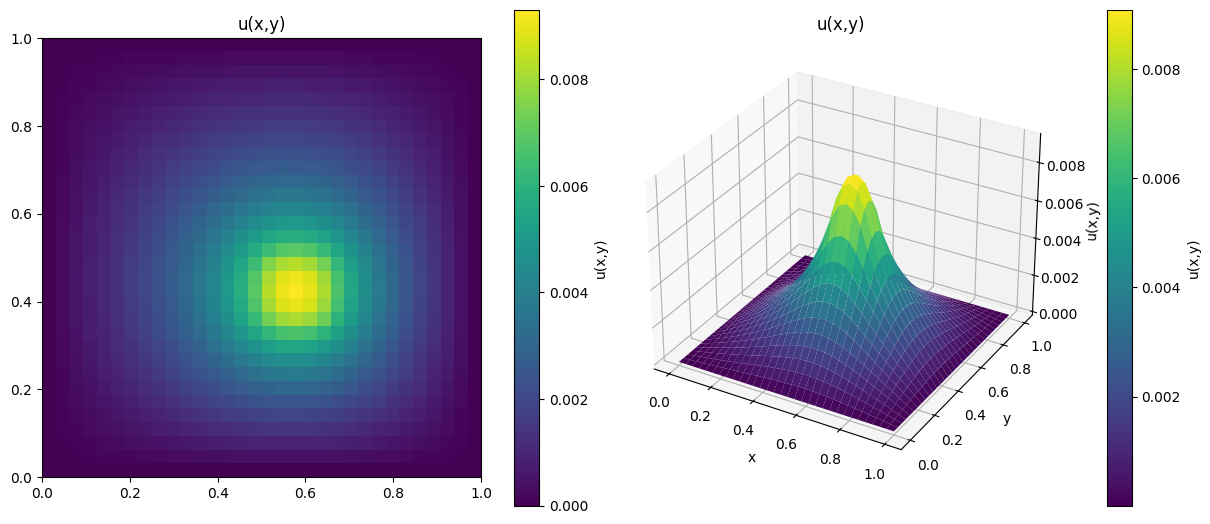

In [9]:
def sor_iteration ( b , w = 1. , u0 = None , tolerance = 1e-5 , max_iteration = 1000 , show_final_stats = False ) :

    """
    Name: sor_iteration
    Purpose: Solve Au=b for u via the succesive over relaxation (SOR) iterative
             method.
    Author: Joshua Belieu | Fletch
    Date written: 2025-10-01
    Last modified: 2025-10-01
    Inputs:
    - b : ndarray. the RHS of the differential equation
    - w : float. the mixing parameter that controls the update of the u 
          iterate.
    - u0 : ndarray. the initial guess for the solution, u. default value is None
           which generates a nxn array of zeros.
    - tolerance : float. the desired tolerance in the convergance of successive 
                  u iterates. default value is 1e-5.
    - max_iteratoin : int. the maximum iterations for the while loop. default
                      value is 1000.
    - show_final_stats : bool. if True, it shows the final iteration and max
                         absolute error.
    Outputs:
    - u : ndarray. an nxn array of the solution.
    - u_iterate_list : list. a collection of u vectors at different iterates
    - iterate_list : list. a collection of iterations.
    Dependencies:
    - boundary conditions. at time of writing homogenous dirichlet boundary
      conditions are used.
    """

    n = b.shape[0]
    h = 1 / ( n - 1 )
    boundary_indices = [ 0 , n - 1  ]

    error = 1.
    iteration = 0

    iterates_list = []
    u_iterate_list = []

    if b.ndim == 1 :
            
            if u0 is None :
                u = np.zeros(shape=(n))
            else :
                u = u0.copy()
            
            while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
                u_new = np.zeros_like ( u )
                iterates_list.append(iteration)
                u_iterate_list.append(u)
                for i in range ( n ) :
                        if i in boundary_indices :
                            u_new[i] = 0 # boundary conditions
                        else : 
                            u_new[i] = 0.5 * w * ( u[i+1] + u_new[i-1] - h ** 2 * b[i] ) + (1-w)*u[i]
                error = u_new - u
                u = u_new
                iteration += 1
    
    elif b.ndim == 2 :

        if u0 is None :
            u = np.zeros(shape=(n,n))
        else :
            u = u0.copy()

        while np.max ( np.abs ( error ) ) > tolerance and iteration < max_iteration :
            u_new = np.zeros_like ( u )
            iterates_list.append(iteration)
            u_iterate_list.append(u)
            for i in range ( n ) :
                for j in range ( n ) :
                    if i in boundary_indices or j in boundary_indices :
                        u_new[i,j] = 0 # boundary conditions
                    else : 
                        u_new[i,j] = 0.25 * w * ( u[i+1,j] + u_new[i-1,j] + u[i,j+1] + u_new[i,j-1] - h ** 2 * b[i,j] ) + (1-w)*u[i,j]
            error = u_new - u
            u = u_new
            iteration += 1

    if show_final_stats == True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print(out_str)

    return u,u_iterate_list,iterates_list

'''
unit test
'''

unit_test_flag = 1

if unit_test_flag == 1 :

    n = 32
    b = np.zeros((n,n))
    x = np.linspace ( 0 , 1 , n );
    y = np.linspace ( 0 , 1 , n );
    for i in range ( n ) :
        for j in range ( n ) :
            if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
                b[i,j] = -1

    u_sol,_,_ = gauss_seidel_iteration(b,tolerance=1e-10,max_iteration=int(1e4),show_final_stats=True)
    X, Y = np.meshgrid(x, x)

    fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
    ax1 = fig.add_subplot ( 121 )
    ax2 = fig.add_subplot ( 122 , projection = '3d' )

    im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
    fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
    ax1.set_title("u(x,y)")

    im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
    fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")
    ax2.set_title("u(x,y)");

w : 0.5 | slope : 9.925e-01 | intercept : 3.753e+01
w : 0.8 | slope : 9.888e-01 | intercept : 2.816e+01
w : 1.0 | slope : 9.857e-01 | intercept : 2.376e+01
w : 1.2 | slope : 9.816e-01 | intercept : 2.018e+01
w : 1.5 | slope : 9.708e-01 | intercept : 1.597e+01
w : 1.8 | slope : 9.210e-01 | intercept : 1.645e+01


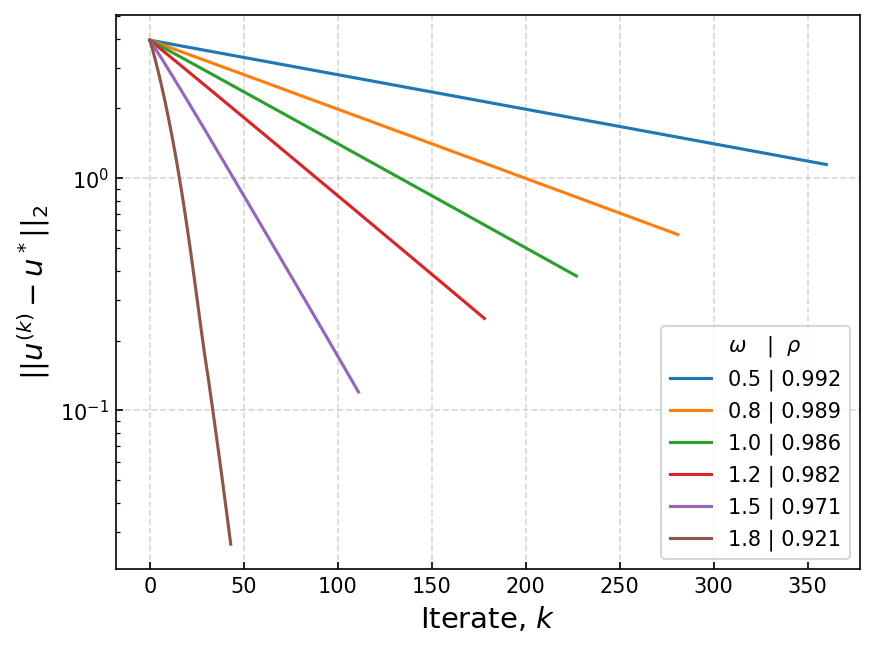

In [10]:
"""
Name: asymptotic rate fitter
Purpose: make a plot showing the convergance of the SOR method and fit a line
         to get some notion of the spectral radius of the iteration matrix.
Author: Joshua Belieu | Fletch
Date written: 2025-10-01
Last modified: 2025-10-02
Inputs:
- n: int. number of mesh points.
- domain (x): array-like. domain of system.
- f : array-like. RHS of ODE
- tolerance : float. tolerance of iterate convergance.
- max_iteration : int. maximum iterations for method.
- w_list : list. collection of mixing parameters for w.
Outputs:
- plot : canvas. a plot of the convergances of the gauss-seidel and jacobi 
         methods.
Dependencies:
- jacobi/gauss_seidel_iteration, numpy, matplotlib
"""

n=32
x = np.linspace(0,1,n)
u_star = np.sin( np.pi * x )
f = -np.pi**2*u_star
w_list = [0.5,0.8,1.0,1.2,1.5,1.8]

sor_l2norm = []
sor_iterates_list = []
slope_list = []
plt.figure(dpi=150)
for w in w_list : 

    u_sor,u_sor_iterates,sor_iterates = sor_iteration ( f ,w=w ,tolerance=1e-3, max_iteration=int(1e6) )
    l2norms = [ np.linalg.norm( np.abs(u_iterate - u_star) ) for u_iterate in u_sor_iterates ]
    sor_l2norm.append(l2norm)
    sor_iterates_list.append(sor_iterates)
    slope , intercept = np.polyfit ( sor_iterates , l2norms , 1 )
    slope_list.append(np.exp(slope))
    print(f"w : {w} | slope : {np.exp(slope):.3e} | intercept : {np.exp(intercept):.3e}")
    plt.plot(sor_iterates,l2norms,label=f"{w} | {np.exp(slope):.3f}")

plt.yscale('log')
plt.legend(title=r'   $\omega$   |  $\rho$')
plt.xlabel(r'Iterate, $k$',fontsize=14)
plt.ylabel(r'$||u^{(k)}-u^*||_2$',fontsize=14)
plt.tick_params(direction='in',which='both')
plt.grid(which='major',ls='--',alpha=0.5);

0.2.c

w : 0.5 | Spec. Rad. : 9.970e-01 | Slope : 9.925e-01 | SR-Slope : 4.520e-03
w : 0.8 | Spec. Rad. : 9.940e-01 | Slope : 9.888e-01 | SR-Slope : 5.220e-03
w : 1.0 | Spec. Rad. : 9.910e-01 | Slope : 9.857e-01 | SR-Slope : 5.314e-03
w : 1.2 | Spec. Rad. : 9.864e-01 | Slope : 9.816e-01 | SR-Slope : 4.879e-03
w : 1.5 | Spec. Rad. : 9.726e-01 | Slope : 9.708e-01 | SR-Slope : 1.841e-03
w : 1.8 | Spec. Rad. : 8.981e-01 | Slope : 9.210e-01 | SR-Slope : -2.290e-02


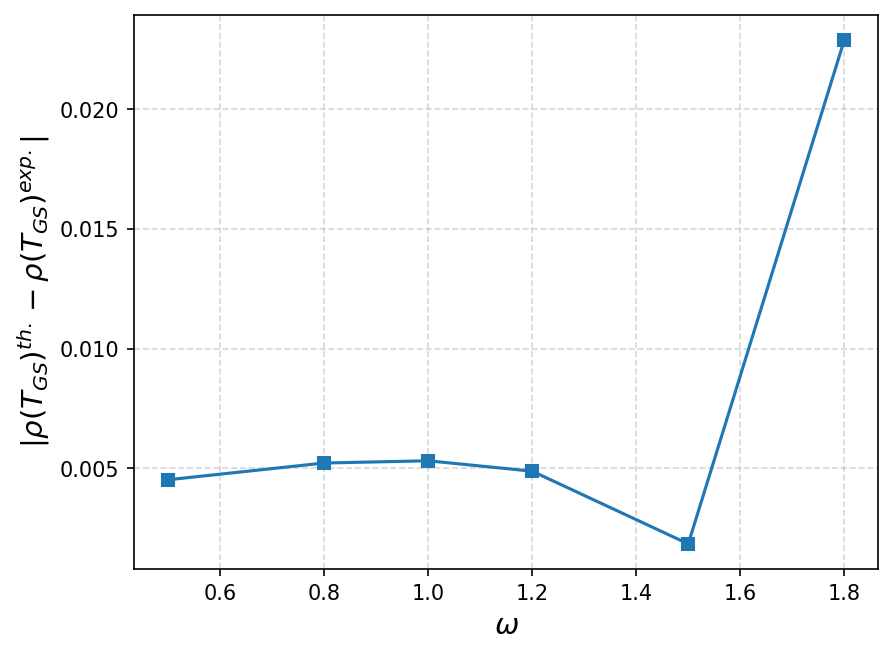

In [11]:
"""
Name: comparing numerical vs theoretical rate
Purpose: compute the spectral radius of the sor iteration matrix and compare its
         value to the slope of the error from the previous problem.
Author: Joshua Belieu | Fletch
Date written: 2025-10-02
Last modified: 2025-10-02
Inputs:
- n : int. number of mesh points
- h : float. mesh stride.
- w_list : list. list of w parameters for SOR
Outputs:
- table : table. table of values containing w, spectral radius, slope, and their
          difference.
- plot : canvas. the plot of w vs |spec. rad. - slope|
Dependencies:
- numpy, diags, spectral_radius, matplotlib
"""

n = 32
h = 1/(n-1)

e = np.ones(n)
D = -2/h**2 * diags( e , offsets=0,shape=(n,n))
U = 1/h**2 * diags( e , offsets=1,shape=(n,n))
L = 1/h**2 * diags( e , offsets=-1,shape=(n,n))

sor_spec_rad_list = []
for i,w in enumerate(w_list) :
    sor_iteration_matrix = -np.linalg.inv ( D.toarray()+w*L.toarray() ) @ ( (1-w)*D.toarray() - w*U.toarray() )
    sor_spectral_radius = spectral_radius(sor_iteration_matrix)
    sor_spec_rad_list.append(sor_spectral_radius)
    print(f"w : {w} | Spec. Rad. : {sor_spectral_radius:.3e} | Slope : {slope_list[i]:.3e} | SR-Slope : {sor_spectral_radius-slope_list[i]:.3e}")

plt.figure(dpi=150)
plt.plot(w_list,np.abs(np.array(sor_spec_rad_list)-np.array(slope_list)),marker='s')
plt.xlabel(r'$\omega$',fontsize=14)
plt.ylabel(r'$|\rho(T_{GS})^{th.}-\rho(T_{GS})^{exp.}|$',fontsize=14)
plt.grid(ls='--',alpha=0.5);

0.3.c

In [ ]:
def jacobi_iteration_with_iteration_matrix ( T , c , u0 = None , 
                                            tolerance = 1e-5 , 
                                            max_iterations = 1000 , 
                                            show_final_stats = False ) :
    """
    Name: jacobi_iteration_with_iteration_matrix
    Purpose: perform Jacobi iteration given its iteration matrix.
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-26ish
    Last modified: 2025-10-11
    Inputs:
    - T : ndarray. Jacobi iteration matrix
    - c : ndarray. the rhs of transformed PDE
    - u0 : ndarray. the initial solution guess. Default value : None
    - tolerance : float. the desired difference tolerance between iterates. 
                  default value : 1e-5
    - max_iterations : int. the maximum number of iterations to converge to the
                       solution of the system. default value : 1000
    - show_final_stats : Bool. Show the final error of iterates and final 
                        iteration count. default value : False
    Outputs:
    - u : ndarray. the most converged solution 
    - u_iterates : ndarray. the list of past iterates
    - iterations_list ; list. a list of all iterations
    Dependencies:
    - numpy
    """

    n = T.shape[0] # dimension of system
    if u0 is None : # if u0 is no, assume it is an array of zeroes.
        u = np.zeros( n )
    else : # else, make a copy of the passed guess!
        u = u0.copy()

    iterations = 0 # while loop counter
    error = 1. # starting error
    u_iterates = [] # bookkeeping
    iterations_list = [] # "

    # loop while tolerance < error and current iter < max iter.
    while error > tolerance and iterations < max_iterations :
        u_iterates.append(u) # track iterates
        iterations_list.append( iterations ) # " iterations

        u_new = T @ u + c # calculate update
        error = np.max ( np.abs ( u - u_new ) ) # calculate error
        u = u_new # update u ansatz

        iterations += 1 # update counter

    if show_final_stats == True : # show final stats if desired!
        
        out_str = f'Final Stats : \n Iteration : {iterations} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print ( out_str )

    return u , u_iterates , iterations_list

def gaussseidel_iteration_with_iteration_matrix ( T , c , u0 = None , 
                                            tolerance = 1e-5 , 
                                            max_iterations = 1000 , 
                                            show_final_stats = False ) :

    """
    Name: gaussseidel_iteration_with_iteration_matrix
    Purpose: perform GS iteration given its iteration matrix.
    Author: Joshua Belieu | Fletch
    Date written: 2025-09-26ish
    Last modified: 2025-10-11
    Inputs:
    - T : ndarray. GS iteration matrix
    - c : ndarray. the rhs of transformed PDE
    - u0 : ndarray. the initial solution guess. Default value : None
    - tolerance : float. the desired difference tolerance between iterates. 
                  default value : 1e-5
    - max_iterations : int. the maximum number of iterations to converge to the
                       solution of the system. default value : 1000
    - show_final_stats : Bool. Show the final error of iterates and final 
                        iteration count. default value : False
    Outputs:
    - u : ndarray. the most converged solution 
    - u_iterates : ndarray. the list of past iterates
    - iterations_list ; list. a list of all iterations
    Dependencies:
    - numpy
    """

    n = T.shape[0] # dimension of system
    if u0 is None : # if guess is none, assume its 0-vec
        u = np.zeros( n )
    else : # else, copy passed guess
        u = u0.copy()

    iterations = 0 # iteration counter
    error = 1. # initial error
    u_iterates = [] # bookkeeping
    iterations_list = [] # "

    # loop while tolerance < error and current iter < max iter.
    while error > tolerance and iterations < max_iterations :
        u_iterates.append(u) # track forms of solution
        iterations_list.append( iterations ) # record iterations

        u_new = T @ u + c # perform GS update
            
        error = np.max ( np.abs ( u - u_new ) ) # calculate error
        iterations += 1 # update counter
        u = u_new # update u

    if show_final_stats == True : # show final stats, if desired.
        
        out_str = f'Final Stats : \n Iteration : {iterations} \n ||Error|| : {np.max(np.abs(error)):.2e}'
        print ( out_str )

    return u , u_iterates , iterations_list

/tmp/ipykernel_5644/3944087409.py:22: RuntimeWarning: overflow encountered in subtract
  error = np.max ( np.abs ( u - u_new ) )
/tmp/ipykernel_5644/3944087409.py:21: RuntimeWarning: overflow encountered in matmul
  u_new = T @ u + c
/tmp/ipykernel_5644/3944087409.py:21: RuntimeWarning: invalid value encountered in matmul
  u_new = T @ u + c
/tmp/ipykernel_5644/3944087409.py:56: RuntimeWarning: overflow encountered in matmul
  u_new = T @ u + c
/tmp/ipykernel_5644/3944087409.py:56: RuntimeWarning: invalid value encountered in matmul
  u_new = T @ u + c
/tmp/ipykernel_5644/3944087409.py:61: RuntimeWarning: invalid value encountered in subtract
  error = np.max ( np.abs ( u - u_new ) )
/home/jabelieu/Desktop/nmfde_class/.venv_nmfde/lib/python3.12/site-packages/numpy/linalg/_linalg.py:2792: RuntimeWarning: overflow encountered in dot
  sqnorm = x.dot(x)


Method : Jacobi | slope : 2.828e+00 | intercept : 2.414e-01
Method : Gauss-Seidel | slope : 2.718e+00 | intercept : 1.000e+00


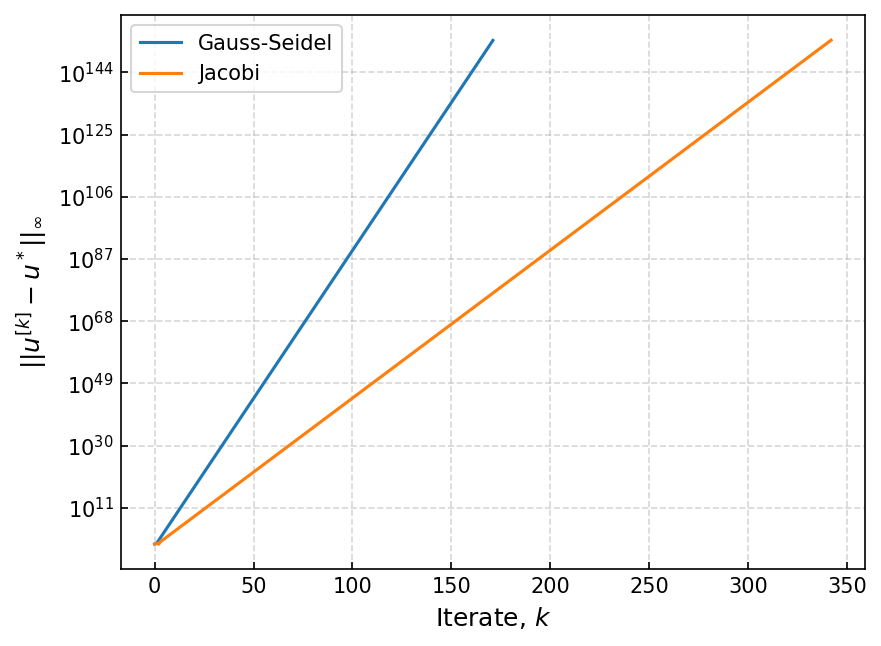

In [ ]:
"""
Name: GS vs J convergance
Purpose: compare methods in last cell via their convergance rates
Author: Joshua Belieu | Fletch
Date written: 2025-09-26ish
Last modified: 2025-10-11
Inputs:
- A : System derivative matrix.
Outputs:
- plot : solution error vs iterate
Dependencies:
- jacobi/gaussseidel_iteration_with_iteration_matrix, numpy, matplotlib
"""

n=3
#ChatGPT generated this tj, i asked what the corresponding A is and it generated:
A=np.array([[-2,-4,0],[-4,-2,-4],[0,-4,-2]])
f = np.array([1]*n) # rhs of PDE
D = np.diag(np.diag(A)) # this and below is decomposition of A.
L = np.tril(A, -1)
U = np.triu(A, 1)

tj  = -np.linalg.inv(D) @ (L + U) # jacobi iteration matrix
cj  = np.linalg.inv(D) @ f # jacobi rhs transform
tgs = -np.linalg.inv(D + L) @ U # gs iteratoin matrix
cgs = np.linalg.inv(D + L) @ f # gs rhs transform

x = np.linspace(0,1,n) # system domain
u_star = np.sin( np.pi * x ) # true solution
u_true = np.linalg.solve(A,f) # solution via alt method
error_list = [] # bookkeeping
gs_error_list = [] # "

# get solutions from both methods
utj_sol , utj_iterates , tj_iterations_list = jacobi_iteration_with_iteration_matrix ( tj , cj )
utgs_sol , utgs_iterates , tgs_iterations_list = gaussseidel_iteration_with_iteration_matrix ( tgs , cgs )
for i in range ( len(utj_iterates) ) : # get error from jacobi

    u_approx_i = utj_iterates[i]
    error = np.linalg.norm(np.abs(u_approx_i-u_star))
    error_list.append(error)

for i in range ( len(utgs_iterates) ) : # repeat for gs

    u_approx_i = utgs_iterates[i]
    error = np.linalg.norm(np.abs(u_approx_i-u_star))
    gs_error_list.append(error)

j_finite_idxs = np.where(np.isfinite(error_list))[0] # there where infs, so i tossed those. 
gs_finite_idxs = np.where(np.isfinite(error_list))[0]

# fit a line to both methods to extract slope and intercept.
jslope , jintercept = np.polyfit ( np.array(tj_iterations_list)[j_finite_idxs],
                                  np.log(np.array(error_list)[j_finite_idxs]), 1 )
gsslope , gsintercept = np.polyfit ( np.array(tgs_iterations_list)[gs_finite_idxs],
                                    np.array(tgs_iterations_list)[gs_finite_idxs] , 1 )

# used for table in writeup
print(f"Method : Jacobi | slope : {np.exp(jslope):.3e} | intercept : {np.exp(jintercept):.3e}")
print(f"Method : Gauss-Seidel | slope : {np.exp(gsslope):.3e} | intercept : {np.exp(gsintercept):.3e}")
# plot!
plt.figure(dpi=150)
plt.plot(tgs_iterations_list,gs_error_list,label='Gauss-Seidel')
plt.plot(tj_iterations_list,error_list,label='Jacobi')
plt.xlabel(r'Iterate, $k$',fontsize=12)
plt.ylabel(r'$||u^{[k]}-u^*||_\infty$',fontsize=12)
plt.yscale('log')
plt.tick_params(direction='in',which='both')
plt.grid(ls='--',alpha=0.5)
plt.legend(fontsize=10);

0.4.b

[0, 66, 132, 198]
[1. 1. 1. 1.] 1.0


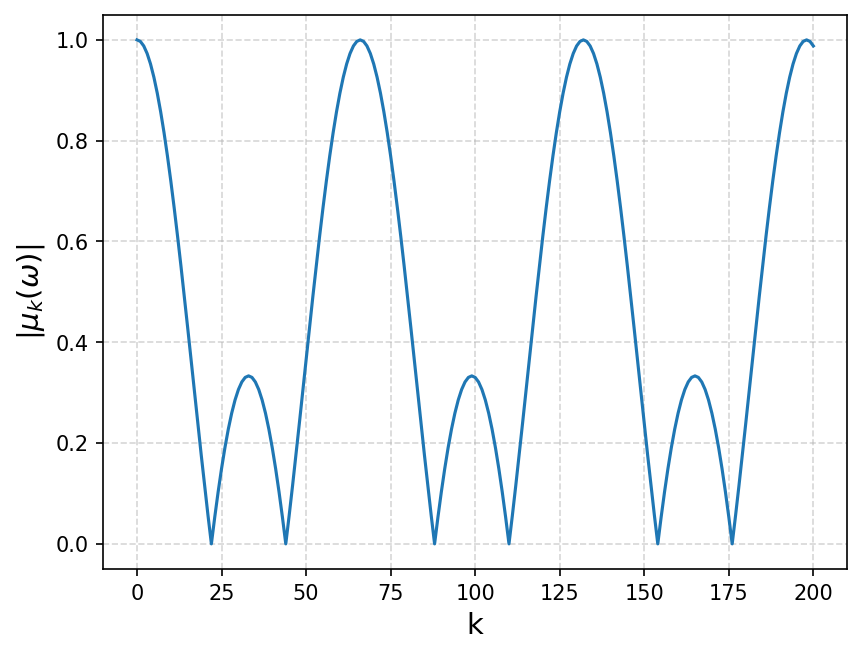

In [21]:
"""
Name: highest damped amplification factor range
Purpose: find highest damped iterates by observing eigenvalues of system
Author: Joshua Belieu | Fletch
Date written: 2025-10-01(ish)
Last modified: 2025-10-11
Inputs:
- n : int. domain size
- w : float. smoother/mixing parameter.
Outputs:
- plot : canvas. mu_k(w) vs k
Dependencies:
- None.
"""

n = 32
w = 2/3
theta_k = lambda k : k * np.pi / ( n + 1 )
mu_k = lambda k : 1-w + w * np.cos ( theta_k(k) )

k_list = np.arange( 0 , 200 + 1 )
mag_mu_k = np.abs ( mu_k ( k_list ) )

max_value = max(mag_mu_k)
max_indices = [i for i, x in enumerate(mag_mu_k) if x == max_value]
print(max_indices)
max_k = mag_mu_k[max_indices]
print(max_k,mag_mu_k[0])

plt.figure(dpi=150)
plt.plot(k_list, mag_mu_k)
plt.xlabel('k',fontsize=14)
plt.ylabel(r'$|\mu_k(\omega)|$',fontsize=14)
plt.grid(ls='--',alpha=0.5);

0.4.c

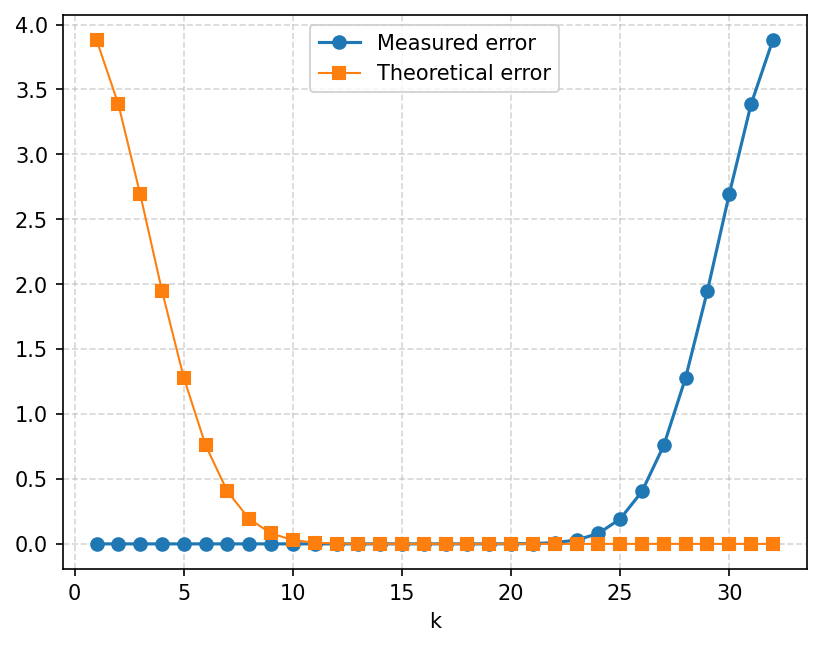

In [26]:
"""
Name: compare theoretical and experimental error
Purpose: compare errors between theory and numerical experiment to showcase
         advantages of multi-grid methods.
Author: Joshua Belieu | Fletch
Date written: 2025-10-01(ish)
Last modified: 2025-10-11
Inputs:
- n : int. domain size
- w : float. smoother/mixing parameter.
- max_steps : int. number of iterates.
Outputs:
- plot : canvas. exp. vs theor. error
Dependencies:
- None.
"""

n = 32
w = 2/3
max_steps = 15 
theta_k = lambda k : k * np.pi / ( n + 1 )
mu_k = lambda k : 1-w + w * np.cos ( theta_k(k) )
i_arr = np.arange ( 1 , n + 1 )
error_measured = []
error_theory = []
Gw = (1-w)*np.eye(n) - 0.5 * w * diags ( [np.ones(n-1)]*2 , offsets = [1,-1] ).toarray() # leveque

for k in range ( 1 , n + 1 ) :

    theta_k_val = theta_k ( k ) # calc. angle
    phi_k = np.sin( theta_k_val * i_arr ) # theor. eigen vec.
    phi_c = phi_k.copy()
    mu_k_val = mu_k ( k ) # exp eigen val. 'guess'

    for step in range(max_steps): # take steps to update phi_c
        phi_c = Gw @ phi_c  # For sine modes, exact update is mu_k * phi

    phi_k *= mu_k(k) ** max_steps # theor eigen vec.
    error_measured.append(np.linalg.norm(phi_c)) # bookkeeping
    error_theory.append(np.linalg.norm(phi_k)) # "

error_measured = np.array(error_measured)
error_theory = np.array(error_theory)
# plot!
plt.figure(dpi=150)
plt.plot(i_arr, error_measured, marker='o', label='Measured error')
plt.plot(i_arr, error_theory, marker='s',lw=1, label='Theoretical error')
plt.grid(ls='--',alpha=0.5)
plt.xlabel('k')
plt.legend();

1.5.b

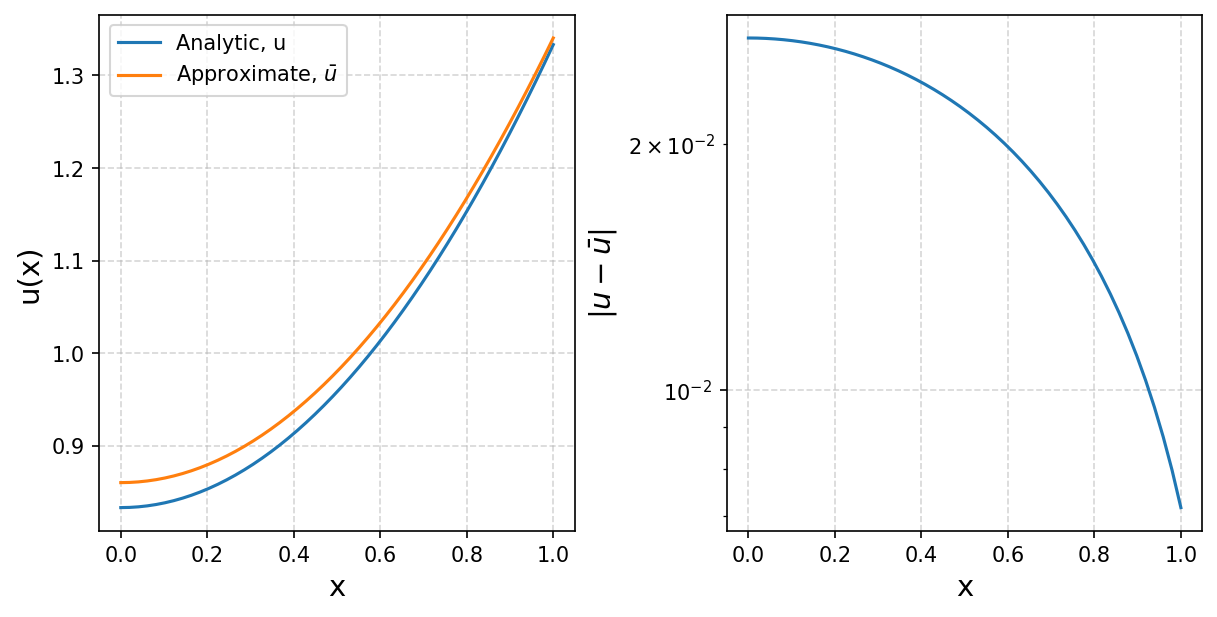

In [16]:
"""
Name: method convergance plot
Purpose: make a plot showing the convergance performance of system ODE.
Author: Joshua Belieu | Fletch
Date written: 2025-09-24
Last modified: 2025-10-01
Inputs:
- x_low/high : float. system domain bounds.
- n : int. number of mesh points
- neumann bcs : array-like. stencil of coefficients for neumann boundary 
                condtion.
- f : array-like. RHS of ODE AND neumann BC/normalization conditon.
Outputs:
- plot : canvas. a plot of the true analytic and approximate solution along with
         the absolute value of their residual.
Dependencies:
- derivative_1d_stencil, fd_weights, csr_matrix, numpy, matplotlib
"""

x_low = 0.
x_high = 1.
n = int(5e1)
h = x_high / ( n )

offsets = [ -1 , 0 , 1 ]
derivative_matrix = derivative_1d_stencil(n,h=h)
stencil_nobc = derivative_matrix.copy()
left_neumann = np.array([ float(num) for num  in np.array(fd_weights ( [0,1,2],1 )).flatten()])

derivative_matrix[0,0:3] = left_neumann / h

f = np.ones ( n-1 )
f[0]=0.

norm_cond = np.ones ( n ) * h
norm_cond[0]=h/2;norm_cond[-1]=h/2
derivative_matrix[-1,:] = norm_cond
f = np.append(f,1.0)

u = spsolve ( csr_matrix(derivative_matrix) , f )

x = np.linspace ( x_low , x_high , n )
true = 0.5*x**2+5/6

fig,axs = plt.subplots(1,2,figsize=(8,4),constrained_layout=True,dpi=150)
axs[0].plot( x , true ,label='Analytic, u')
axs[0].plot( x , u , label = r'Approximate, $\bar{u}$')
axs[0].set_xlabel('x', fontsize=14)
axs[0].set_ylabel('u(x)', fontsize=14)
axs[0].grid(ls='--',alpha=0.5)
axs[1].plot( x , np.abs(u - true))
axs[1].set_xlabel('x', fontsize=14)
axs[1].set_ylabel(r'$|u-\bar{u}|$', fontsize=14)
axs[1].set_yscale('log')
axs[1].grid(ls='--',alpha=0.5)
axs[0].legend();

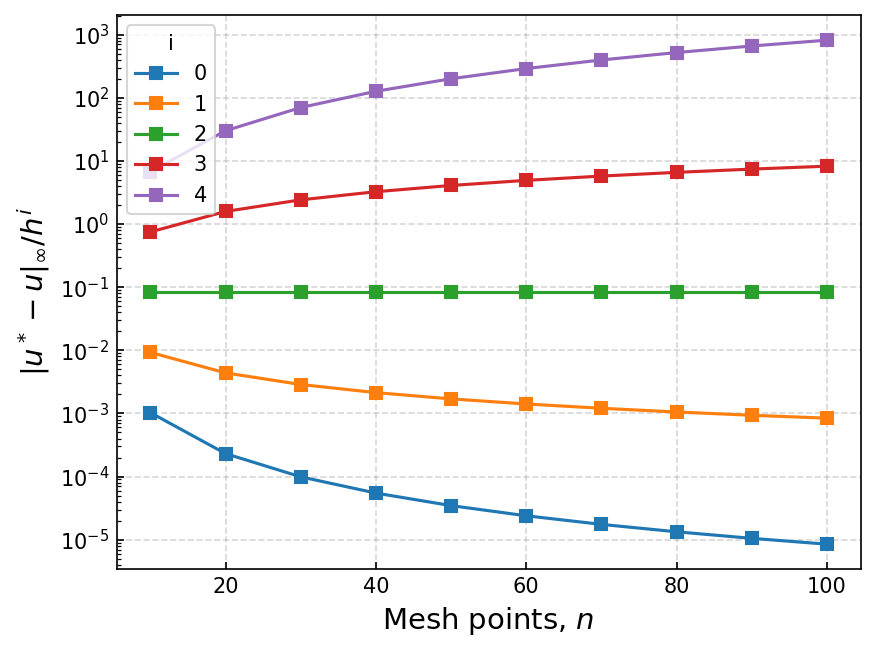

In [17]:
"""
Name: order tester
Purpose: test the order of a method at different step sizes.
Author: Joshua Belieu | Fletch
Date written: 2025-09-24
Last modified: 2025-10-01
Inputs:
- x_low/high : floats. system domain limits.
- n_list : array-like. array of ints giving mesh grid size.
- offsets : list. offsets of stencil
- ODE conditions : multi. neumann boundary condition and normalization 
                   condition.
- f : array-like. blend of ODE RHS and condition values.
Outputs:
- plot : n_list vs error/(h^i). this shows what the order of the method is.
         curves with slope ~ 0 are the order.
Dependencies:
- fd_weights, derivatie_1d_stencil, numpy, matplotlib
"""

x_low = 0.
x_high = 1.
n_list = range(10,110,10)

offsets = [ -1 , 0 , 1 ]
h_list = []
max_error_list = []

for n in n_list : 

    h = x_high / ( n-1 )

    derivative_matrix = derivative_1d_stencil(n,h=h)

    left_neumann = np.array([ float(num) for num  in np.array(fd_weights ( [0,1,2,3],1 )).flatten()])

    derivative_matrix[0,0:len(left_neumann)] = left_neumann / h

    f = np.ones ( n-1 )
    f[0]=0.

    norm_cond = np.ones ( n ) * h
    norm_cond[0]=h/2;norm_cond[-1]=h/2
    derivative_matrix[-1,:] = norm_cond
    f = np.append(f,1.0)

    u = spsolve ( csr_matrix(derivative_matrix) , f )    
    x = np.linspace ( x_low , x_high , n )
    true = 0.5*x**2+5/6

    h_list.append(h)
    max_error_list.append ( np.max ( np.abs ( u - true )))
plt.figure(dpi=150)
for order in range ( 0 , 4 + 1 ) :
    plt.plot ( n_list , np.array(max_error_list)/np.array(h_list)**order ,label=order,marker='s')
plt.yscale('log')
plt.grid(ls='--',alpha=0.5,which='major')
plt.xlabel( r'Mesh points, $n$',fontsize=14 )
plt.ylabel (r'$|u^*-u|_\infty/h^i$',fontsize=14)
plt.tick_params(direction='in',which='both')
plt.legend(title='i');

3.9

In [ ]:

def sor_no_matrix_mk1 ( f=None , n = 5 , w = 1. , a = None , h = None , u0 = None , 
                   max_iterations = 1000 , tolerance = 1e-5 , show_final_stats = True ) :
    
    """
    Name: sor_no_matrix_mk1
    Purpose: do SOR w/o a ,atrix
    Author: Joshua Belieu | Fletch
    Date written: 2025-10-05(ish)
    Last modified: 2024-10-11
    Inputs:
    - f : ndarray. rhs of PDE
    - n  : int. system resolution, lattice points
    - w : float. smoother/mixing parameter. default value : 1 (should perform 
          like GS)
    - a : ndarray. diffusion coefficient matrix. default value : None
    - h : float. system stride. default value : None
    - u0 : ndarray. initial guess
    - max_iterations : int. maximum number of iterates. default value : 1000
    - tolerance : float. desired difference between iterates. default value : 
                  1e-5
    show_final_stats : bool. print final error and iteratoin to terminal. 
                       default value : True
    Outputs:
    - u : ndarray. most converged solution to PDE
    - iteration : int. final iteration count
    Dependencies:
    - None
    """

    if h is None :
        # print('lattice spacing not specified, assuming h=1/(n-1).')
        h = 2/(n-1)
    if u0 is None : 
        u = np.zeros ( (n , n) )
    else :
        u = u0.copy()
    if f is None : 
        f = np.zeros(n,n)
    if a is None : 
        a = np.ones((n,n))

    iteration = 0
    iteration_list = []
    error = np.inf
    while ( error > tolerance and iteration < max_iterations ) :
        iteration_list.append(iteration)
        error = 0.

        for j in  range ( n ) :
            for i in  range ( n ) :
                u_center = u[i,j]
                if i + 1 < n :
                    u_right = u [ i+1 , j ]
                else :
                    u_right = 0.
                if i - 1 >= 0 :
                    u_left = u [ i-1 , j ]
                else :
                    u_left = 0.
                if j + 1 < n :
                    u_up = u [ i , j+1 ]
                else :
                    u_up = 0.
                if j - 1 >= 0 :
                    u_down = u [ i , j-1 ]
                else : 
                    u_down = 0.
                if ( i+1<n and j+1<n ) :
                    u_upper_right = u [ i+1 , j+1 ]
                else :
                    u_upper_right = 0.
                if ( i-1>=0 and j+1<n ) :
                    u_upper_left = u [ i-1 , j+1 ]
                else :
                    u_upper_left = 0.
                if ( i+1<n and j-1>=0 ) :
                    u_lower_right = u [ i+1 , j-1 ]
                else :
                    u_lower_right = 0.
                if ( i-1>=0 and j-1>=0 ) :
                    u_lower_left = u [ i-1 , j-1 ]
                else :
                    u_lower_left = 0. # this block of code makes me sad and ChatGPT 
                                      # reccomends a more succinct stlye. i.e.,
                                      # u_bottom = u[i,j-1] if j-1 >= 0 else 0.0
                
                a_center = a[i,j]
                a_right = a[i+1,j] if i+1 < n else a[i,j]
                a_left = a[i-1,j] if i-1 >= 0 else a[i,j]
                a_up = a[i,j+1] if j+1 < n else a[i,j]
                a_down = a[i,j-1] if j-1 >= 0 else a[i,j]
                # u_laplacian = ( 4 * ( u_left + u_right + u_down + u_up ) + \
                #     u_lower_left + u_lower_right + u_upper_left + u_upper_right - \
                #     20 * u_center ) / ( 6 * h ** 2 )
                u_laplacian = ( 4 * ( u_left + u_right + u_down + u_up ) + \
                    u_lower_left + u_lower_right + u_upper_left + u_upper_right)/( 6 * h ** 2 )# - \
                    #20 * u_center ) / ( 6 * h ** 2 )
                # u_laplacian = (u_left + u_right + u_up + u_down - 4*u_center)/(h**2)
                
                if 0 < i < n-1 :
                    dadx_dudx = ( a_right - a_left )*( u_right - u_left ) / (4 * h**2)
                else :
                    dadx_dudx = 0.
                if 0 < j < n-1 :
                    dady_dudy = ( a_up - a_down )*( u_up - u_down ) / (4 * h**2)
                else :
                    dady_dudy = 0.

                rhs = -f[i,j] - a_center * u_laplacian - dadx_dudx - dady_dudy

                u_new = (1-w) * u_center + w * rhs/(-20 * a_center / (6*h**2)) # rhs/(.) is test
                error = max(error,abs( u_new - u_center ))
                u[i,j] = u_new

        iteration += 1
    
    if show_final_stats is True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {np.abs(error):.2e}'
        print(out_str)
    
    return u , iteration

'''
unit test
'''

unit_test_flag = 0

if unit_test_flag == 1 :

    n = 32
    b = np.zeros((n,n))
    x = np.linspace ( 0 , 1 , n );
    y = np.linspace ( 0 , 1 , n );
    for i in range ( n ) :
        for j in range ( n ) :
            if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
                b[i,j] = 1
    X, Y = np.meshgrid(x, x)
    # a = 1+X
    u_sol , _ = sor_no_matrix_mk1(f=b,n=n,w=0.5,a=np.ones((n,n)),max_iterations=int(1e4),tolerance=1e-10)

    fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
    ax1 = fig.add_subplot ( 121 )
    ax2 = fig.add_subplot ( 122 , projection = '3d' )

    im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
    fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
    ax1.set_title("u(x,y)")

    im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
    fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")
    ax2.set_title("u(x,y)");

Final Stats : 
 Iteration : 3313 
 ||Error|| : 9.99e-11


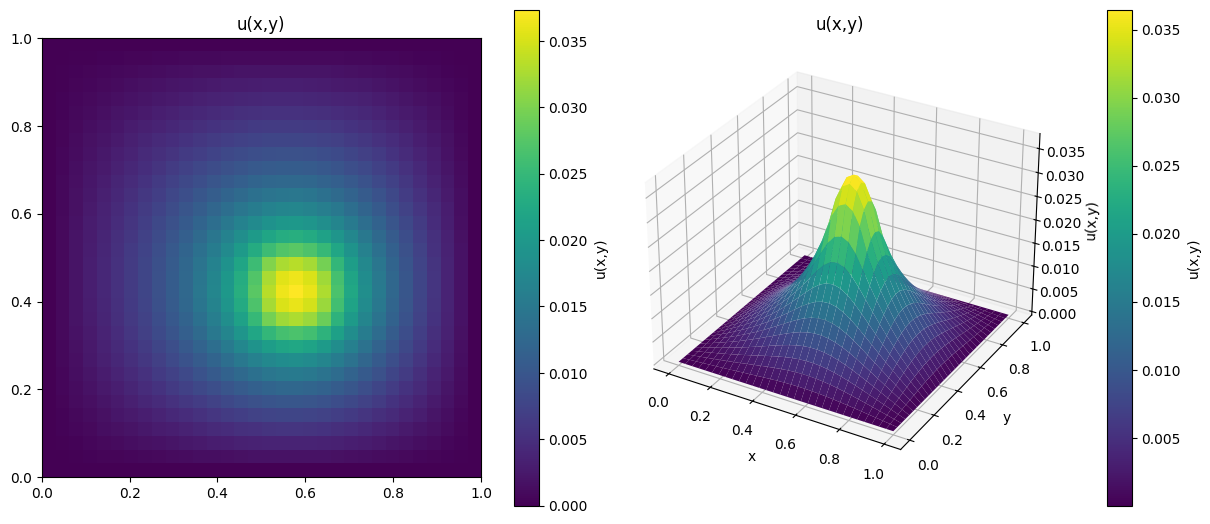

In [ ]:
def sor_no_matrix ( f=None , n = 5 , w = 1. , a = None , h = None , u0 = None , 
                   max_iterations = 1000 , tolerance = 1e-5 , show_final_stats = True ) :
    
    """
    Name: sor_no_matrix_mk1
    Purpose: do SOR w/o a ,atrix
    Author: Joshua Belieu | Fletch
    Date written: 2025-10-07(ish)
    Last modified: 2024-10-11
    Inputs:
    - f : ndarray. rhs of PDE
    - n  : int. system resolution, lattice points
    - w : float. smoother/mixing parameter. default value : 1 (should perform 
          like GS)
    - a : ndarray. diffusion coefficient matrix. default value : None
    - h : float. system stride. default value : None
    - u0 : ndarray. initial guess
    - max_iterations : int. maximum number of iterates. default value : 1000
    - tolerance : float. desired difference between iterates. default value : 
                  1e-5
    show_final_stats : bool. print final error and iteratoin to terminal. 
                       default value : True
    Outputs:
    - u : ndarray. most converged solution to PDE
    - iteration : int. final iteration count
    Dependencies:
    - None
    """

    if h is None :
        # print('lattice spacing not specified, assuming h=1/(n-1).')
        h = 2/(n-1)
    if u0 is None : 
        u = np.zeros ( (n , n) )
    else :
        u = u0.copy()
    if f is None : 
        f = np.zeros(n,n)
    if a is None : 
        a = np.ones((n,n))

    iteration = 0
    iteration_list = []
    error = np.inf
    while ( error > tolerance and iteration < max_iterations ) :
        iteration_list.append(iteration)
        error = 0.

        for j in  range ( 1,n-1 ) :
            for i in  range ( 1,n-1 ) :
                u_center = u[i,j]
                if i + 1 < n :
                    u_right = u [ i+1 , j ]
                else :
                    u_right = 0.
                if i - 1 >= 0 :
                    u_left = u [ i-1 , j ]
                else :
                    u_left = 0.
                if j + 1 < n :
                    u_up = u [ i , j+1 ]
                else :
                    u_up = 0.
                if j - 1 >= 0 :
                    u_down = u [ i , j-1 ]
                else : 
                    u_down = 0.
                if ( i+1<n and j+1<n ) :
                    u_upper_right = u [ i+1 , j+1 ]
                else :
                    u_upper_right = 0.
                if ( i-1>=0 and j+1<n ) :
                    u_upper_left = u [ i-1 , j+1 ]
                else :
                    u_upper_left = 0.
                if ( i+1<n and j-1>=0 ) :
                    u_lower_right = u [ i+1 , j-1 ]
                else :
                    u_lower_right = 0.
                if ( i-1>=0 and j-1>=0 ) :
                    u_lower_left = u [ i-1 , j-1 ]
                else :
                    u_lower_left = 0. # this block of code makes me sad and ChatGPT 
                                      # reccomends a more succinct stlye. i.e.,
                                      # u_bottom = u[i,j-1] if j-1 >= 0 else 0.0
                
                a_center = a[i,j]
                a_right = a[i+1,j] if i+1 < n else a[i,j]
                a_left = a[i-1,j] if i-1 >= 0 else a[i,j]
                a_up = a[i,j+1] if j+1 < n else a[i,j]
                a_down = a[i,j-1] if j-1 >= 0 else a[i,j]
                # u_laplacian = ( 4 * ( u_left + u_right + u_down + u_up ) + \
                #     u_lower_left + u_lower_right + u_upper_left + u_upper_right - \
                #     20 * u_center ) / ( 6 * h ** 2 )
                u_laplacian = ( 4 * ( u_left + u_right + u_down + u_up ) + \
                    u_lower_left + u_lower_right + u_upper_left + u_upper_right)/( 6 * h ** 2) - \
                    20 * u_center  / ( 6 * h ** 2 )
                # u_laplacian = (u_left + u_right + u_up + u_down - 4*u_center)/(h**2)
                
                if 0 < i < n-1 :
                    dadx_dudx = ( a_right - a_left )*( u_right - u_left ) / (4 * h**2)
                else :
                    dadx_dudx = 0.
                if 0 < j < n-1 :
                    dady_dudy = ( a_up - a_down )*( u_up - u_down ) / (4 * h**2)
                else :
                    dady_dudy = 0.

                rhs = -f[i,j] - a_center * u_laplacian - dadx_dudx - dady_dudy

                # u_new = (1-w) * u_center + w * rhs#/(-20 * a_center / (6*h**2)) # rhs/(.) is test
                u_new = (1 - w)*u_center + w * (
    4*(u_left + u_right + u_up + u_down)
    + (u_lower_left + u_lower_right + u_upper_left + u_upper_right)
    + (6*h**2/a_center)*f[i,j]
) / 20.0
                error = max(error,abs( u_new - u_center ))
                u[i,j] = u_new

        iteration += 1
    
    if show_final_stats is True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {np.abs(error):.2e}'
        print(out_str)
    
    return u , iteration

'''
unit test
'''

unit_test_flag = 1

if unit_test_flag == 1 :

    n = 32
    b = np.zeros((n,n))
    x = np.linspace ( 0 , 1 , n );
    y = np.linspace ( 0 , 1 , n );
    for i in range ( n ) :
        for j in range ( n ) :
            if 1/3 <= x[i] <= 1/2 and 1/2 <= y[j] <= 2/3 :
                b[i,j] = 1
    X, Y = np.meshgrid(x, x)
    # a = 1+X
    u_sol , _ = sor_no_matrix(f=b,n=n,w=0.5,a=np.ones((n,n)),max_iterations=int(1e4),tolerance=1e-10)

    fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
    ax1 = fig.add_subplot ( 121 )
    ax2 = fig.add_subplot ( 122 , projection = '3d' )

    im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
    fig.colorbar(im1 , label="u(x,y)",ax=ax1 , shrink = 0.5 )
    ax1.set_title("u(x,y)")

    im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
    fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.set_zlabel("u(x,y)")
    ax2.set_title("u(x,y)");

w:0.1,0.00% Complete
w:0.4636363636363636,20.00% Complete
w:0.8272727272727273,40.00% Complete
w:1.5545454545454547,80.00% Complete


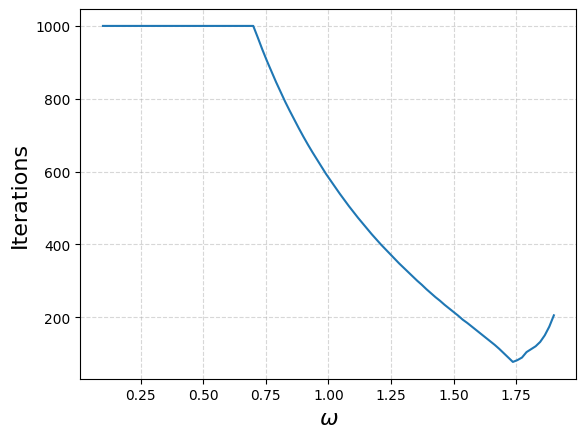

In [ ]:
"""
Name: optimal w search
Purpose: using the sor with no matrix function, can we find the most optimal w?
         (the w which mimnimizes iterations).
Author: Joshua Belieu | Fletch
Date written: 2025-10-05
Last modified: 2025-10-11
Inputs:
- w_list : list. list of ws to explore
- n : int. domain size, lattice points
Outputs:
- plot : canvas. iterations vs w.
Dependencies:
- sor_no_matrix
"""

w_list = np.linspace(0.1 , 1.9 , 100 )
n = 20
x = np.linspace ( -1 , 1 , n )
y = np.linspace ( -1 , 1 , n )
X,Y = np.meshgrid(x,y)
u_star = np.sin(np.pi*Y)*np.cos(np.pi*X)
f = -np.pi**2*u_star
a = np.ones((n,n))

err_list = []
iter_list = []
for w in w_list :
    if np.where(w_list==w)[0][0]/len(w_list) % .2 == 0 :
        print(f"w:{w},{np.where(w_list==w)[0][0]/len(w_list):.2%} Complete")
    u_sol , last_iter = sor_no_matrix(f=f,n=n,w=w,a=np.ones((n,n)),max_iterations=int(1e3),tolerance=1e-10,show_final_stats=False)
    if np.any(np.isnan(u_sol)):
        continue
    err_inf = np.max(np.abs(u_sol-u_star))
    err_list.append(err_inf)
    iter_list.append(last_iter)
plt.plot(w_list,iter_list)
plt.xlabel(r'$\omega$',fontsize=16)
plt.ylabel(r'Iterations',fontsize=16)
plt.grid(ls='--',alpha=0.5)
plt.show()

3.10

In [ ]:
"""
Name: order tester
Purpose: is the order of the sor_no_matrix 4th order for constant a?
Author: Joshua Belieu | Fletch
Date written: 2025-10-07(ish)
Last modified: 2025-10-11
Inputs:
- n_list : ndarray. list of lattice points.
Outputs:
- ret: plot : canvas. error/h^i vs n_list. (next cell)
Dependencies:
- sor_no_matrix
"""

n_list = np.arange ( 10 , 50 + 1 , 10 )
error_list = []
h_list = []

for n in n_list :
    h = 2/(n-1)
    x = np.linspace(-1,1,n)
    y = np.linspace(-1,1,n)
    X,Y = np.meshgrid(x,y)
    a = np.ones((n,n))
    u_star = np.sin(np.pi*(X-1))*np.sin(2*np.pi*(Y-1))
    f = 5 * np.pi ** 2 * u_star
    u0 = np.zeros((n,n))

    u_sol,_ = sor_no_matrix (f=f,n=n,w=1.75,a=a,h=h,u0=u0,
                           max_iterations=1e3,tolerance=1e-10,
                           show_final_stats=False)
    error = np.max(np.abs(u_sol-u_star))
    error_list.append(error)
    h_list.append(h)

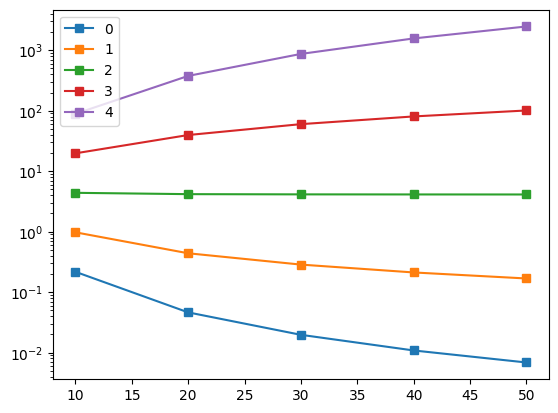

In [85]:
# plt.plot(n_list,error_list);
for order in range ( 0 , 4 + 1 ) :
    plt.plot ( n_list , np.array(error_list)/np.array(h_list)**order ,label=order,marker='s')

plt.yscale('log')
plt.legend()
plt.show()

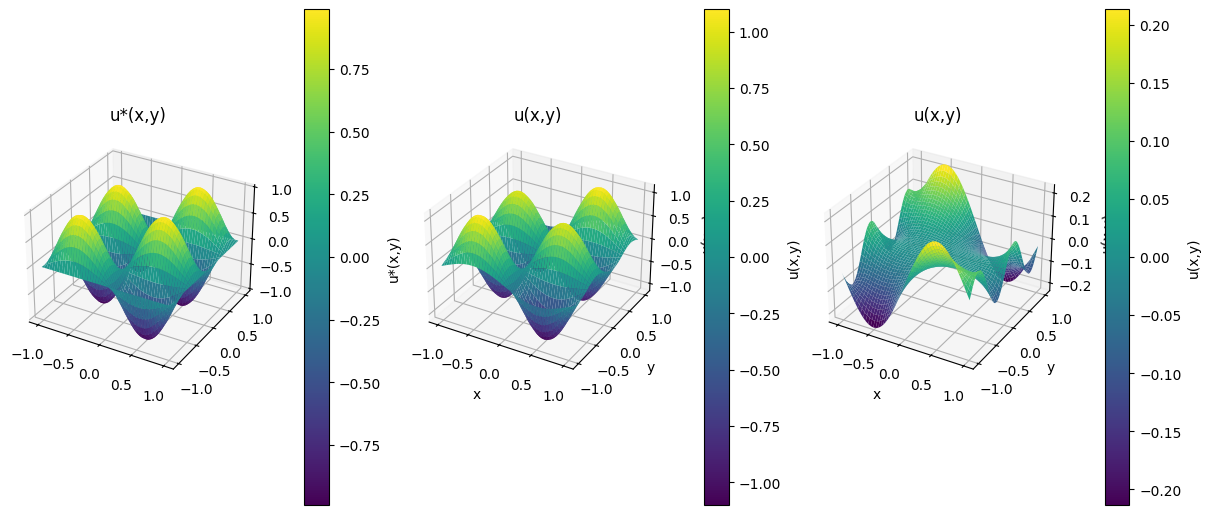

In [69]:
X, Y = np.meshgrid(x, x)
# a = 1+X
fig = plt.figure ( figsize = ( 12 , 10 ) , constrained_layout=True )
ax1 = fig.add_subplot ( 131 ,projection='3d')
ax2 = fig.add_subplot ( 132 , projection = '3d' )
ax3 = fig.add_subplot ( 133 , projection = '3d' )

# im1 = ax1.imshow(u_sol, origin="lower", extent=[0,1,0,1])
im1 = ax1.plot_surface(X, Y, u_star, cmap='viridis', edgecolor="none")
fig.colorbar(im1 , label="u*(x,y)",ax=ax1 , shrink = 0.5 )
ax1.set_title("u*(x,y)")

im2 = ax2.plot_surface(X, Y, u_sol, cmap='viridis', edgecolor="none")
fig.colorbar(im2 , shrink = 0.5 , aspect=20, label="u(x,y)")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_zlabel("u(x,y)")
ax2.set_title("u(x,y)");
im3 = ax3.plot_surface(X, Y, u_star-u_sol, cmap='viridis', edgecolor="none")
fig.colorbar(im3 , shrink = 0.5 , aspect=20, label="u(x,y)")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
ax3.set_zlabel("u(x,y)")
ax3.set_title("u(x,y)");

4.12.b

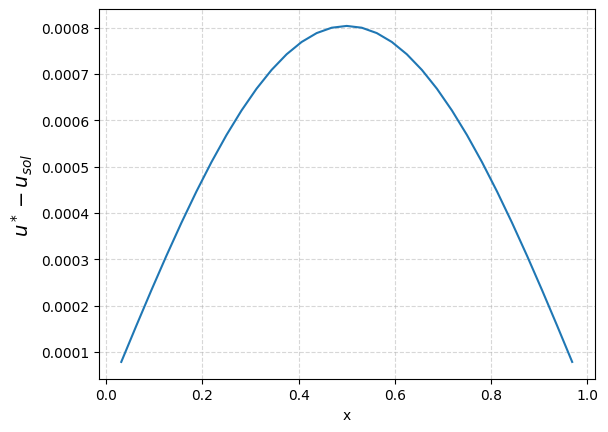

In [5]:
def weighted_jacobi ( A , f , u0 = None , w = 1. , max_iterations = int(1e3) , tolerance = 1e-5 , show_final_stats = False ) :

    """
    Name: weighted_jacobi
    Purpose: solve a given system using a weighted jacobi smoother
    Author: Joshua Belieu | Fletch
    Date written: 2025-10-11
    Last modified: 2025-10-11
    Inputs:
    - arg1: type ... meaning/units/shape
    - arg2: type ... meaning/units/shape
    Outputs:
    - ret: type ... meaning/units/shape
    Dependencies:
    - SubroutineA, SubroutineB, ...
    """

    D = np.diag ( A )
    D_inv = 1/D
    n = A.shape[0]
    if u0 is None :
        u = np.zeros(n)
    else :
        u = u0.copy()

    error = np.inf
    iteration = 0

    iteration_list = []
    u_iterate_list = []

    while tolerance < error and iteration < max_iterations :

        iteration_list.append ( iteration )
        u_iterate_list.append ( u )

        u_new = u + w * D_inv * ( f - A @ u )

        error = np.max ( np.abs ( u - u_new ) )
        iteration += 1

        u = u_new

    if show_final_stats == True :
        out_str = f'Final Stats : \n Iteration : {iteration} \n ||Error|| : {np.abs(error):.2e}'
        print(out_str)

    return u , u_iterate_list , iteration_list

'''
unit test
'''

unit_test_flag = 1

if unit_test_flag == 1 :

    n = 32
    n_int = n-1
    x0=1
    h = x0/(n_int+1)
    k=0
    x = np.linspace ( h , x0-h , n_int )
    u_star = np.sin( np.pi * x )
    f = (np.pi**2 + k**2) * u_star
    A_no_k2 = -derivative_1d_stencil ( n=n_int,offsets=[-1,0,1],order=2,h=h )
    A = A_no_k2 + np.diag ( k**2* np.ones(n_int) )

    u_sol ,_,_ = weighted_jacobi(A=A,f=f,w=2/3,max_iterations=int(1e4),tolerance=1e-20)

    plt.plot(x,u_sol-u_star)
    plt.xlabel('x')
    plt.ylabel(r'$u^*-u_{sol}$',fontsize=14)
    plt.grid(ls='--',alpha=0.5)

w:0.1,0.00% Complete
w:0.3020202020202021,20.00% Complete
w:0.5040404040404041,40.00% Complete
w:0.9080808080808082,80.00% Complete


/tmp/ipykernel_4649/3531057372.py:37: RuntimeWarning: overflow encountered in matmul
  u_new = u + w * D_inv * ( f - A @ u )
/tmp/ipykernel_4649/3531057372.py:37: RuntimeWarning: invalid value encountered in matmul
  u_new = u + w * D_inv * ( f - A @ u )
/tmp/ipykernel_4649/3531057372.py:37: RuntimeWarning: invalid value encountered in add
  u_new = u + w * D_inv * ( f - A @ u )


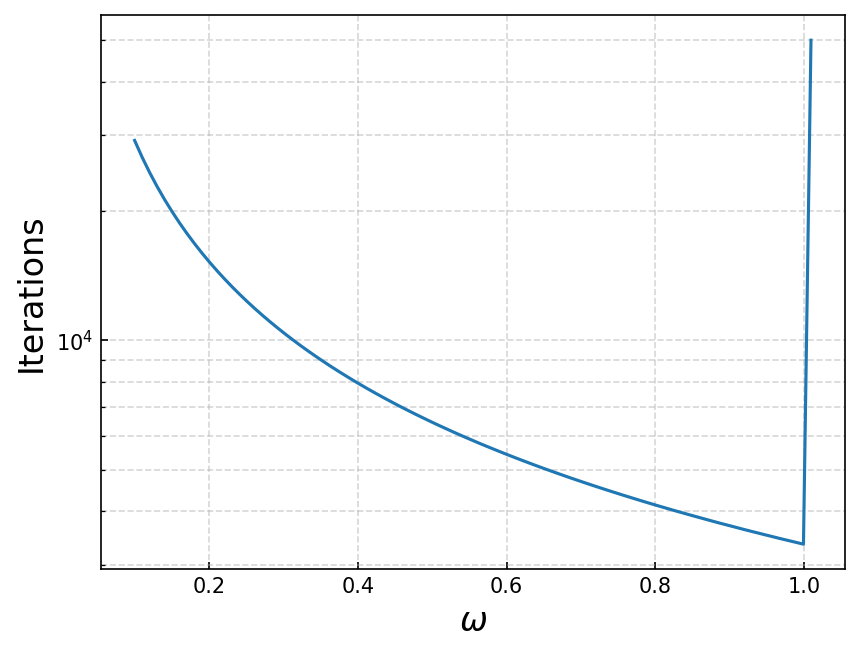

In [36]:
"""
Name: optimal w search
Purpose: using the weighted jacobi can we find the most optimal w?
         (the w which mimnimizes iterations).
Author: Joshua Belieu | Fletch
Date written: 2025-10-11
Last modified: 2025-10-11
Inputs:
- w_list : list. list of ws to explore
- n : int. domain size, lattice points
Outputs:
- plot : canvas. iterations vs w.
Dependencies:
- sor_no_matrix
"""

w_list = np.linspace(.1 , 1.1 , 100 )
# w_list = np.array([ 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 2/3 , 0.7 , 0.8 , 0.9 ])
n = 32
n_int = n-1
x0=1
h = x0/(n_int+1)
k=1
x = np.linspace ( h , x0-h , n_int )
u_star = np.sin( np.pi * x )
f = (np.pi**2 + k**2) * u_star
A_no_k2 = -derivative_1d_stencil ( n=n_int,offsets=[-1,0,1],order=2,h=h )
A = A_no_k2 + np.diag ( k**2* np.ones(n_int) )
GwJ = lambda w :  np.diag(np.ones(A.shape[0])) - w * 1/(np.diag(A))*A
rho_list = []

err_list = []
iter_list = []
for w in w_list :
    if np.where(w_list==w)[0][0]/len(w_list) % .2 == 0 :
        print(f"w:{w},{np.where(w_list==w)[0][0]/len(w_list):.2%} Complete")
    u_sol ,_,last_iter = weighted_jacobi(A=A,f=f,w=w,max_iterations=int(5e4),tolerance=1e-10)
    G = GwJ ( w )
    rho = spectral_radius ( G )
    rho_list.append(rho)
    if np.any(np.isnan(u_sol)):
        continue
    err_inf = np.max(np.abs(u_sol-u_star))
    err_list.append(err_inf)
    iter_list.append((last_iter[-1],w))

iters_count, w_vals = zip(*iter_list)
plt.figure(dpi=150)
plt.plot(w_vals,iters_count)
plt.xlabel(r'$\omega$',fontsize=16)
plt.ylabel(r'Iterations',fontsize=16)
plt.yscale('log')
plt.tick_params(direction='in',which='both')
plt.grid(ls='--',which='both',alpha=0.5);

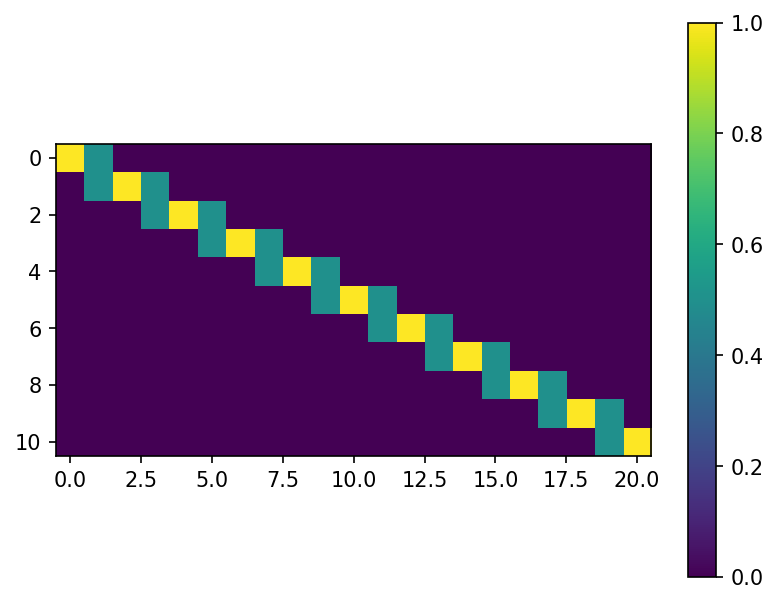

In [50]:
def build_interpolation_matrix ( coarse_resolution ) :

    fine_resolution = 2 * coarse_resolution - 1
    # fine_resolution = 2 * coarse_resolution
    interpolation_matrix = np.zeros ( ( fine_resolution , coarse_resolution ) )
    for coarse_index in range ( coarse_resolution ) :
        fine_index = 2 * coarse_index
        interpolation_matrix [ fine_index , coarse_index ] = 1.
        if fine_index + 1 < fine_resolution :
            interpolation_matrix [ fine_index + 1 , coarse_index ] += 0.5
        if fine_index - 1 >= 0 :
            interpolation_matrix [ fine_index - 1 , coarse_index ] += 0.5

    return interpolation_matrix

nc=11
nf=2*nc

xc=np.linspace(0,2*np.pi,nc)
xf=np.linspace(0,2*np.pi,nf)
vc = np.sin(xc)
size = 200
size_coeff = 1/4
plt.figure(dpi=150)
interp_mat = build_interpolation_matrix ( nc )
vf = interp_mat @ vc

plt.imshow(interp_mat.T)
plt.colorbar();
# plt.scatter(xc,vc,s=size)
# plt.scatter(xf,vf,s=.25*size);
# plt.plot(np.linspace(0,2*np.pi,100),np.sin(np.linspace(0,2*np.pi,100)),color='green');

(50, 99) (99,)


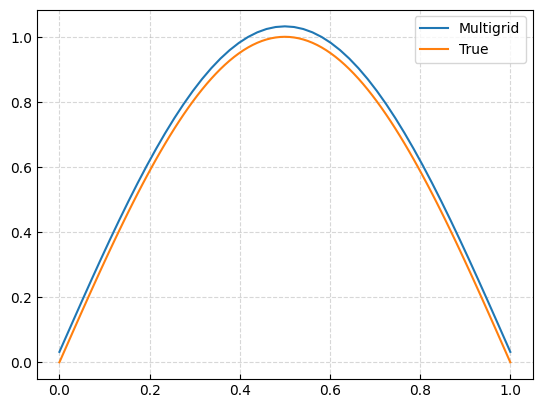

In [54]:
def one_step_weighted_jacobi ( A , u , f , w ) :

    """
    Name: one_step_weighted_jacobi
    Purpose: Calculate one step in the weighted jacobi scheme. This is a single
    step towards the solution of Au=f.
    Author: Joshua Belieu | Fletch
    Date written: 2025-10-15
    Last modified: 2025-10-15
    Inputs:
    - A : ndarray. the derivative matrix of the system
    - u : ndarray. the n-th iteration of a solution
    - f : ndarray. the RHS of the differential equation.
    - w : float. the mixing parameter that controls how much of the update is
    combined with the current form of the solution.
    Outputs:
    - u_new : ndarray. the (n+1)-th iteration of a solution.
    Dependencies:
    - Numpy.
    """

    D = np.diag ( A )

    u_new = u + w * ( f - A @ u ) / D

    return u_new

def two_cycle_vgrid ( Ah , fh , interpolation_matrix , restriction_matrix , nu1 ,
                      nu2 , w , coarse_steps = 10 , u0 = None , cheeky_solve = False ) :
    
    if u0 is None :
        u = np.zeros_like ( fh )
    else :
        u = u0.copy()
    for iteration in range ( nu1 ) :
        u = one_step_weighted_jacobi ( Ah , u , fh , w )

    r = fh - Ah @ u

    print(restriction_matrix.shape,r.shape)

    r2h = restriction_matrix @ r
    A2h = restriction_matrix @ Ah @ interpolation_matrix

    if cheeky_solve == True :
        error_coarse = scp.linalg.solve ( A2h , r2h )
    else :
        for i in range ( coarse_steps ) :
            error_coarse = one_step_weighted_jacobi ( A=A2h,u=np.zeros_like(r2h),f=r2h,w=w )
    
    u += interpolation_matrix @ error_coarse

    for iteration in range ( nu2 ) :
        u = one_step_weighted_jacobi ( A=Ah , u=u, f=fh , w=w )

    return u

'''
unit test
'''

n_h = 100 - 1
n_2h = (n_h + 1)//2

x = np.linspace(0, 1, n_h)
u_star = np.sin(np.pi * x)
fh = -np.pi**2 * u_star
Ah = derivative_1d_stencil(n=n_h, offsets=[-1,0,1], order=2, h=1/(n_h-1))

interp_mat = build_interpolation_matrix(n_2h)
restric_mat = 0.5 * interp_mat.T

u_sol = two_cycle_vgrid(
    Ah=Ah,fh=fh,interpolation_matrix=interp_mat,restriction_matrix=restric_mat,
    nu1=3,nu2=3,w=1.,cheeky_solve=True)

plt.plot(x,u_sol,label='Multigrid')
plt.plot(x,u_star,label='True')
plt.legend()
plt.tick_params(direction='in')
plt.grid(ls='--',alpha=0.5)
plt.show()

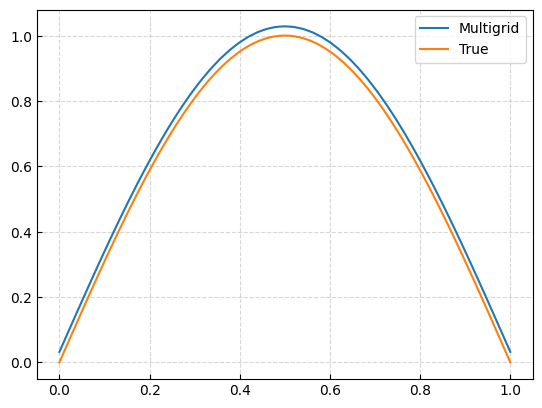

In [84]:
n_h = 100 - 1
n_2h = (n_h + 1)//2
k=1

x = np.linspace(0, 1, n_h)
u_star = np.sin(np.pi * x)
fh = (np.pi**2 + k ** 2) * u_star
Ah = -derivative_1d_stencil(n=n_h, offsets=[-1,0,1], order=2, h=1/(n_h-1))+np.diag ( k**2* np.ones(n_h))

interp_mat = build_interpolation_matrix(n_2h)
restric_mat = 0.5 * interp_mat.T

u_sol = two_cycle_vgrid(
    Ah=Ah,fh=fh,interpolation_matrix=interp_mat,restriction_matrix=restric_mat,
    nu1=3,nu2=3,w=0.9,cheeky_solve=True)

plt.plot(x,u_sol,label='Multigrid')
plt.plot(x,u_star,label='True')
plt.legend()
plt.tick_params(direction='in')
plt.grid(ls='--',alpha=0.5)
plt.show()

In [57]:
n_points = 20
k_list = np.linspace ( 0 , 10 , n_points )
h_list = np.linspace ( 1e-3 , 1e-1 , n_points )
good_k_list = []
good_h_list = []
error_list = []
master_list = []

for h in h_list :
    for k in k_list :
        n_fine = int(1/h + 1)
        n_coarse = (n_fine+1)//2
        print(f"h={h:.2e},k={k:.2f}, n_fine={n_fine},n_coarse={n_coarse}")

        x = np.linspace(0, 1, n_fine)
        u_star = np.sin(np.pi * x)
        fh = (np.pi**2 + k ** 2) * u_star
        Ah = -derivative_1d_stencil(n=n_fine, offsets=[-1,0,1], order=2, h=1/(n_fine-1))+np.diag ( k**2* np.ones(n_fine))

        interp_mat = build_interpolation_matrix(n_coarse)
        restric_mat = 0.5 * interp_mat.T

        u_sol = two_cycle_vgrid(
            Ah=Ah,fh=fh,interpolation_matrix=interp_mat,restriction_matrix=restric_mat,
            nu1=3,nu2=3,w=0.9,cheeky_solve=True)

        error = np.linalg.norm ( u_sol - u_star )
        
        error_list.append ( np.linalg.norm ( u_sol - u_star ) )
        good_k_list.append(k)
        good_h_list.append(h)

converganve_factors = np.array(error_list [1:]) / np.array(error_list [:-1])
max_new=1.;min_new=0.5
alpha_h = (np.array(good_h_list)-min(good_h_list))/(max(good_h_list)-min(good_h_list))* (max_new - min_new) + min_new
alpha_k = (np.array(good_k_list)-min(good_k_list))/(max(good_k_list)-min(good_k_list))* (max_new - min_new) + min_new


fig,axs = plt.subplots ( 1,2,figsize=(14,6) )
axs[0].scatter(good_k_list[1:],converganve_factors)#,alpha=alpha_h[1:])
axs[1].scatter(good_h_list[1:],converganve_factors)#,alpha=alpha_k[1:])
axs[0].set_yscale('log')
axs[1].set_yscale('log')


h=1.00e-03,k=0.00, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=0.53, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=1.05, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=1.58, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=2.11, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=2.63, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=3.16, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=3.68, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=4.21, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=4.74, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=5.26, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=5.79, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=6.32, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=6.84, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=7.37, n_fine=1001,n_coarse=501
(501, 1001) (1001,)
h=1.00e-03,k=7.89, n_fine=1001,n_coarse=

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 162 is different from 161)